Read and Explore

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")


print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)


print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())
print(testingSet.describe())

train.csv shape is  (139753, 9)
test.csv shape is  (13976, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0  1049849  B000MR9D5E  A1EKSETIBS9ETQ                     0   
1   999834  B000GAKFIG   AR0HFYHYHDGQQ                     2   
2   218826  6300215776  A37S3ACL57LN62                    11   
3   796384  B00019071C  A1TO1P3NV7OAU6                     2   
4  1219784  B001NFNFN0   ATCM1W7HWIC6U                     0   

   HelpfulnessDenominator        Time  \
0                       0  1198281600   
1                       5  1245024000   
2                      15  1126137600   
3                       2  1351036800   
4                       0  1381708800   

                                             Summary  \
0  Great nature series, but not all scenes looked...   
1                 Agatha Christie's Marple: Series 2   
2                             Childish Entertainment   
3                       The weakest Babylon 5 season   
4                        

Feature Extraction

In [12]:
import pandas as pd
import numpy as np

def process(df):
    # Drop irrelevant columns
    df = df.drop(columns=['ProductId', 'UserId'])
    # Create HelpfulnessRatio column
    df['HelpfulnessRatio'] = np.where(df['HelpfulnessDenominator'] > 0,
                                df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)

    # Convert Time to datetime and create new features for year, month, day, and day of week
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek

    # Length of review text
    df['ReviewLength'] = df['Text'].str.split().str.len()

    # Number of exclamation marks
    df['NumExclamation'] = df['Text'].str.count('!')

    # Number of capital letters
    df['NumCaps'] = df['Text'].str.findall(r'[A-Z]').str.len()

    # Ratio of capital letters to review length
    df['CapsRatio'] = df['NumCaps'] / df['ReviewLength']

    df["Review"] = df["Summary"] + " " + df["Text"]

    # Check correlations with Score and select relevant columns
    corr_matrix = df.corr()
    relevant_cols = corr_matrix['Score'][corr_matrix['Score'].abs() >= 0.08].index.tolist()
    relevant_cols.remove('Score')
    df = df[relevant_cols + ['Id', 'Score', 'Review']]

    print("Relevant columns with corr_matrix score >= 0.08 are: " + str(relevant_cols))

    return df

trainingSet = pd.read_csv("./data/train.csv")
train_processed = process(trainingSet)

display(train_processed.head())

submissionSet = pd.read_csv("./data/test.csv")

testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

display(testX.head())

trainX = train_processed[train_processed['Score'].notnull()]

testX.to_csv("./model/X_test.csv", index=False)
trainX.to_csv("./model/X_train.csv", index=False)

Model Creation

R^2 on testing set =  0.5276554272341696
MAE on testing set =  0.5988535391747627
RMSE on testing set =  0.6662103983736107


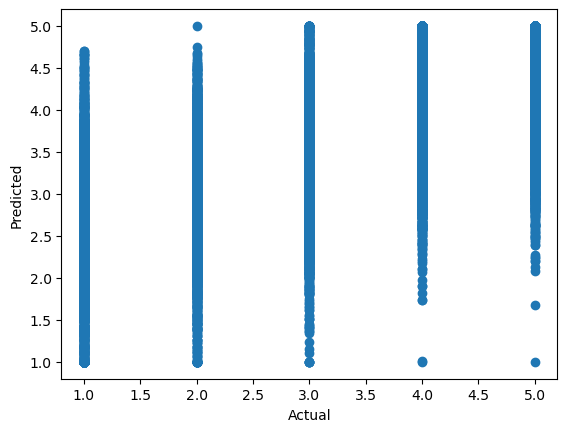

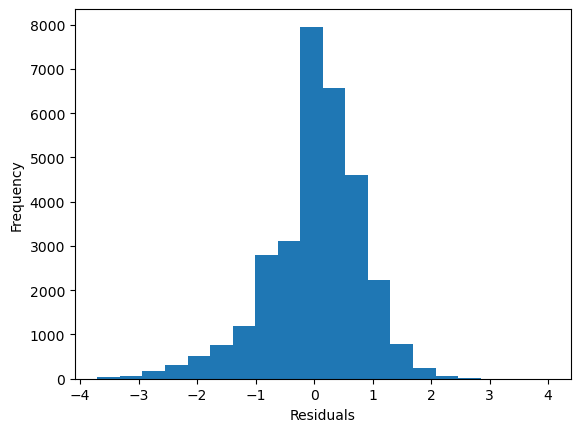

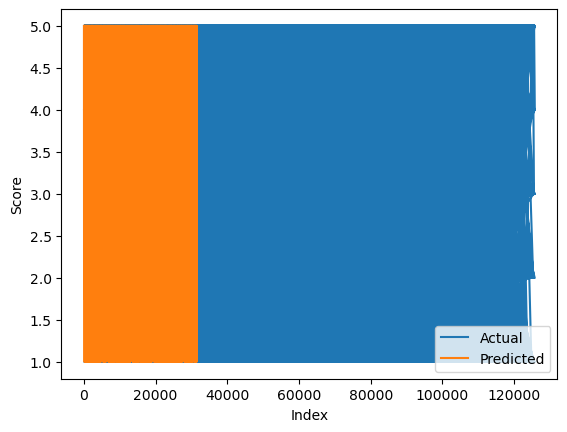

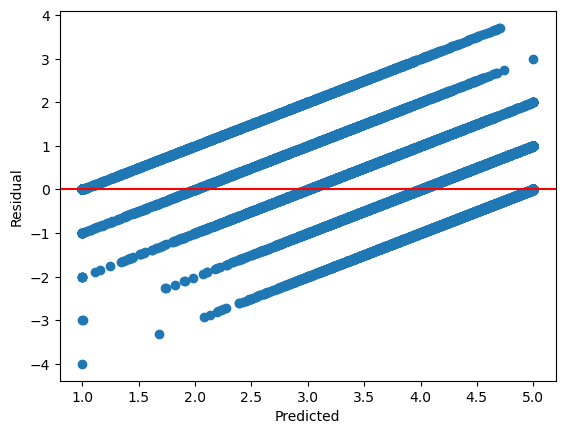

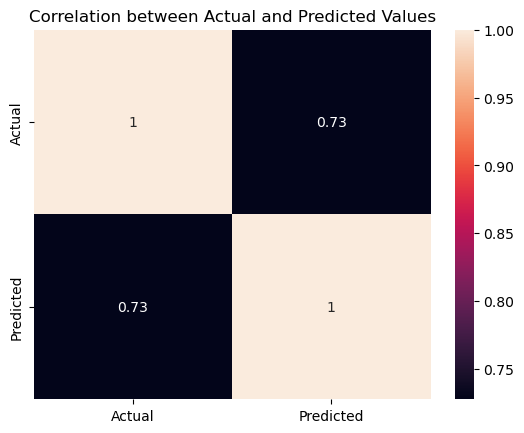

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns

# Load training set with new features into DataFrame
X_train = pd.read_csv("./model/X_train.csv")

# Replace missing values with an empty string
X_train['Review'].fillna('', inplace=True)

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4,
        random_state=0
)

# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id'])
X_test_processed = X_test.drop(columns=['Id'])

# Convert Review data into numerical features using CountVectorizer and TfidfVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train_processed['Review'])
tfidf_transformer = TfidfVectorizer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_processed['Review'])

# Learn the model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_tfidf, Y_train)

# pickle model - saves it so you can load it later
with open('./model/ridge_model.obj', 'wb') as f:
        pickle.dump(ridge, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

# Evaluate your model on the testing set
X_test_counts = count_vect.transform(X_test_processed['Review'])
X_test_tfidf = tfidf_transformer.transform(X_test_processed['Review'])
Y_test_predictions = ridge.predict(X_test_tfidf).clip(1, 5)

# Calculate R^2 and MAE
r2 = r2_score(Y_test, Y_test_predictions)
mae = mean_absolute_error(Y_test, Y_test_predictions)

print("R^2 on testing set = ", r2)
print("MAE on testing set = ", mae)
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

# Save submission DataFrame to CSV file
testX.to_csv("./submission22.csv", index=False)

# Plot your results
plt.scatter(Y_test, Y_test_predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

residuals = Y_test - Y_test_predictions
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.plot(Y_test, label='Actual')
plt.plot(Y_test_predictions, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Score')
plt.legend()
plt.show()

residuals = Y_test_predictions - Y_test
plt.scatter(Y_test_predictions, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

# create a dataframe with actual and predicted values
df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_test_predictions})

# create a heatmap
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation between Actual and Predicted Values')
plt.show()

Create submission file for upload

In [9]:
# Load test set into DataFrame
X_submission = pd.read_csv("./submission22.csv")
display(X_submission.head())
X_submission_processed = X_submission.drop(columns=['Id'])

# Replace missing values with -1
X_submission_processed.fillna(-1, inplace=True)

# Replace missing values with an empty string
X_submission_processed['Review'] = X_submission_processed['Review'].apply(lambda x: '' if type(x)==int else x)

# Convert Review data into numerical features using CountVectorizer and TfidfVectorizer
X_submission_counts = count_vect.transform(X_submission_processed['Review'])
X_submission_tfidf = tfidf_transformer.transform(X_submission_processed['Review'])

# Predict scores for test set
Y_submission_predictions = ridge.predict(X_submission_tfidf).clip(1, 5)

# Replace missing scores with predictions in test set
X_submission['Score'] = Y_submission_predictions

# Create submission DataFrame with Id and Score columns
submission = X_submission[['Id', 'Score']]
display(submission.head())
# Save submission DataFrame to CSV file
submission.to_csv("./submissionn.csv", index=False)

,HelpfulnessDenominator,HelpfulnessRatio,Year,Id,Review,Score
0,1,0.0,2014,1224650,Sherlock Holmes I bought this thinking it was ...,NaN
1,2,1.0,2008,1019381,"FINE SINGING, DESTRUCTIVE STAGING 1. Scenic de...",NaN
2,11,1.0,2002,504719,Moving story of Jesus's message in a modern re...,NaN
3,0,-1.0,2013,1622425,Paul Anka has aged well and performs well I wa...,NaN
4,2,0.5,2000,482286,Great end to the series.Or is it??????????? De...,NaN


,Id,Score
0,1224650,4.164856
1,1019381,2.729412
2,504719,4.013753
3,1622425,4.786658
4,482286,4.943627
